<a href="https://colab.research.google.com/github/sthite175/Tomatto-Leaf-Disease-Prediction-Using-CNN/blob/main/13_08_2023_Tomatto_Leaf_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [3]:
!kaggle datasets download -d shylesh101/tomato-leaf-disease

100% 370M/370M [00:18<00:00, 21.7MB/s]
100% 370M/370M [00:18<00:00, 20.6MB/s]


In [4]:
!chmod 600 ~/.kaggle/kaggle.json

In [5]:
from zipfile import ZipFile
path="/content/tomato-leaf-disease.zip"
with ZipFile(path,'r') as zip:
  zip.extractall()
  print("Dataset Extracted")

Dataset Extracted


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras

from PIL import Image
import cv2
import matplotlib.image as mpimg

In [7]:
"/content/tomato_dataset/test"

'/content/tomato_dataset/test'

In [8]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(
 "/content/tomato_dataset/train",
    batch_size=64,
  image_size=(256,256), shuffle=True
)

Found 18345 files belonging to 10 classes.


In [9]:
# test data have less images hence we take valid data as test data
val_data = tf.keras.preprocessing.image_dataset_from_directory(
 "tomato_dataset/test",
    batch_size=64,
  image_size=(256,256), shuffle=True
)

Found 50 files belonging to 10 classes.


In [10]:
test_data = tf.keras.preprocessing.image_dataset_from_directory(
 "tomato_dataset/valid",
    batch_size=64,
  image_size=(256,256), shuffle=True
)

Found 4585 files belonging to 10 classes.


In [11]:
print(len(train_data))
print(len(test_data))
print(len(val_data))

287
72
1


In [12]:
class_label=train_data.class_names
class_label

['Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot',
 'Tomato___Tomato_Yellow_Leaf_Curl_Virus',
 'Tomato___Tomato_mosaic_virus',
 'Tomato___healthy']

In [13]:
for image_batch,image_label in train_data.take(1):
    print(image_batch[0])
    print(class_label[image_label[0].numpy()])

tf.Tensor(
[[[ 74.  90. 141.]
  [ 68.  84. 135.]
  [ 64.  80. 131.]
  ...
  [124. 147. 199.]
  [124. 149. 206.]
  [125. 149. 209.]]

 [[ 72.  88. 139.]
  [ 73.  89. 140.]
  [ 74.  90. 141.]
  ...
  [122. 145. 197.]
  [120. 145. 202.]
  [121. 145. 205.]]

 [[ 68.  84. 135.]
  [ 76.  92. 143.]
  [ 82.  98. 149.]
  ...
  [121. 144. 196.]
  [118. 143. 199.]
  [118. 143. 200.]]

 ...

 [[ 87. 111. 115.]
  [ 82. 105. 111.]
  [ 79. 101. 112.]
  ...
  [112. 134. 181.]
  [113. 135. 182.]
  [114. 136. 183.]]

 [[ 74.  97. 103.]
  [ 71.  94. 102.]
  [ 70.  92. 106.]
  ...
  [114. 136. 183.]
  [114. 136. 183.]
  [114. 136. 183.]]

 [[ 66.  89.  95.]
  [ 63.  86.  94.]
  [ 64.  85. 102.]
  ...
  [117. 139. 186.]
  [115. 137. 184.]
  [114. 136. 183.]]], shape=(256, 256, 3), dtype=float32)
Tomato___Leaf_Mold


# Train Image data

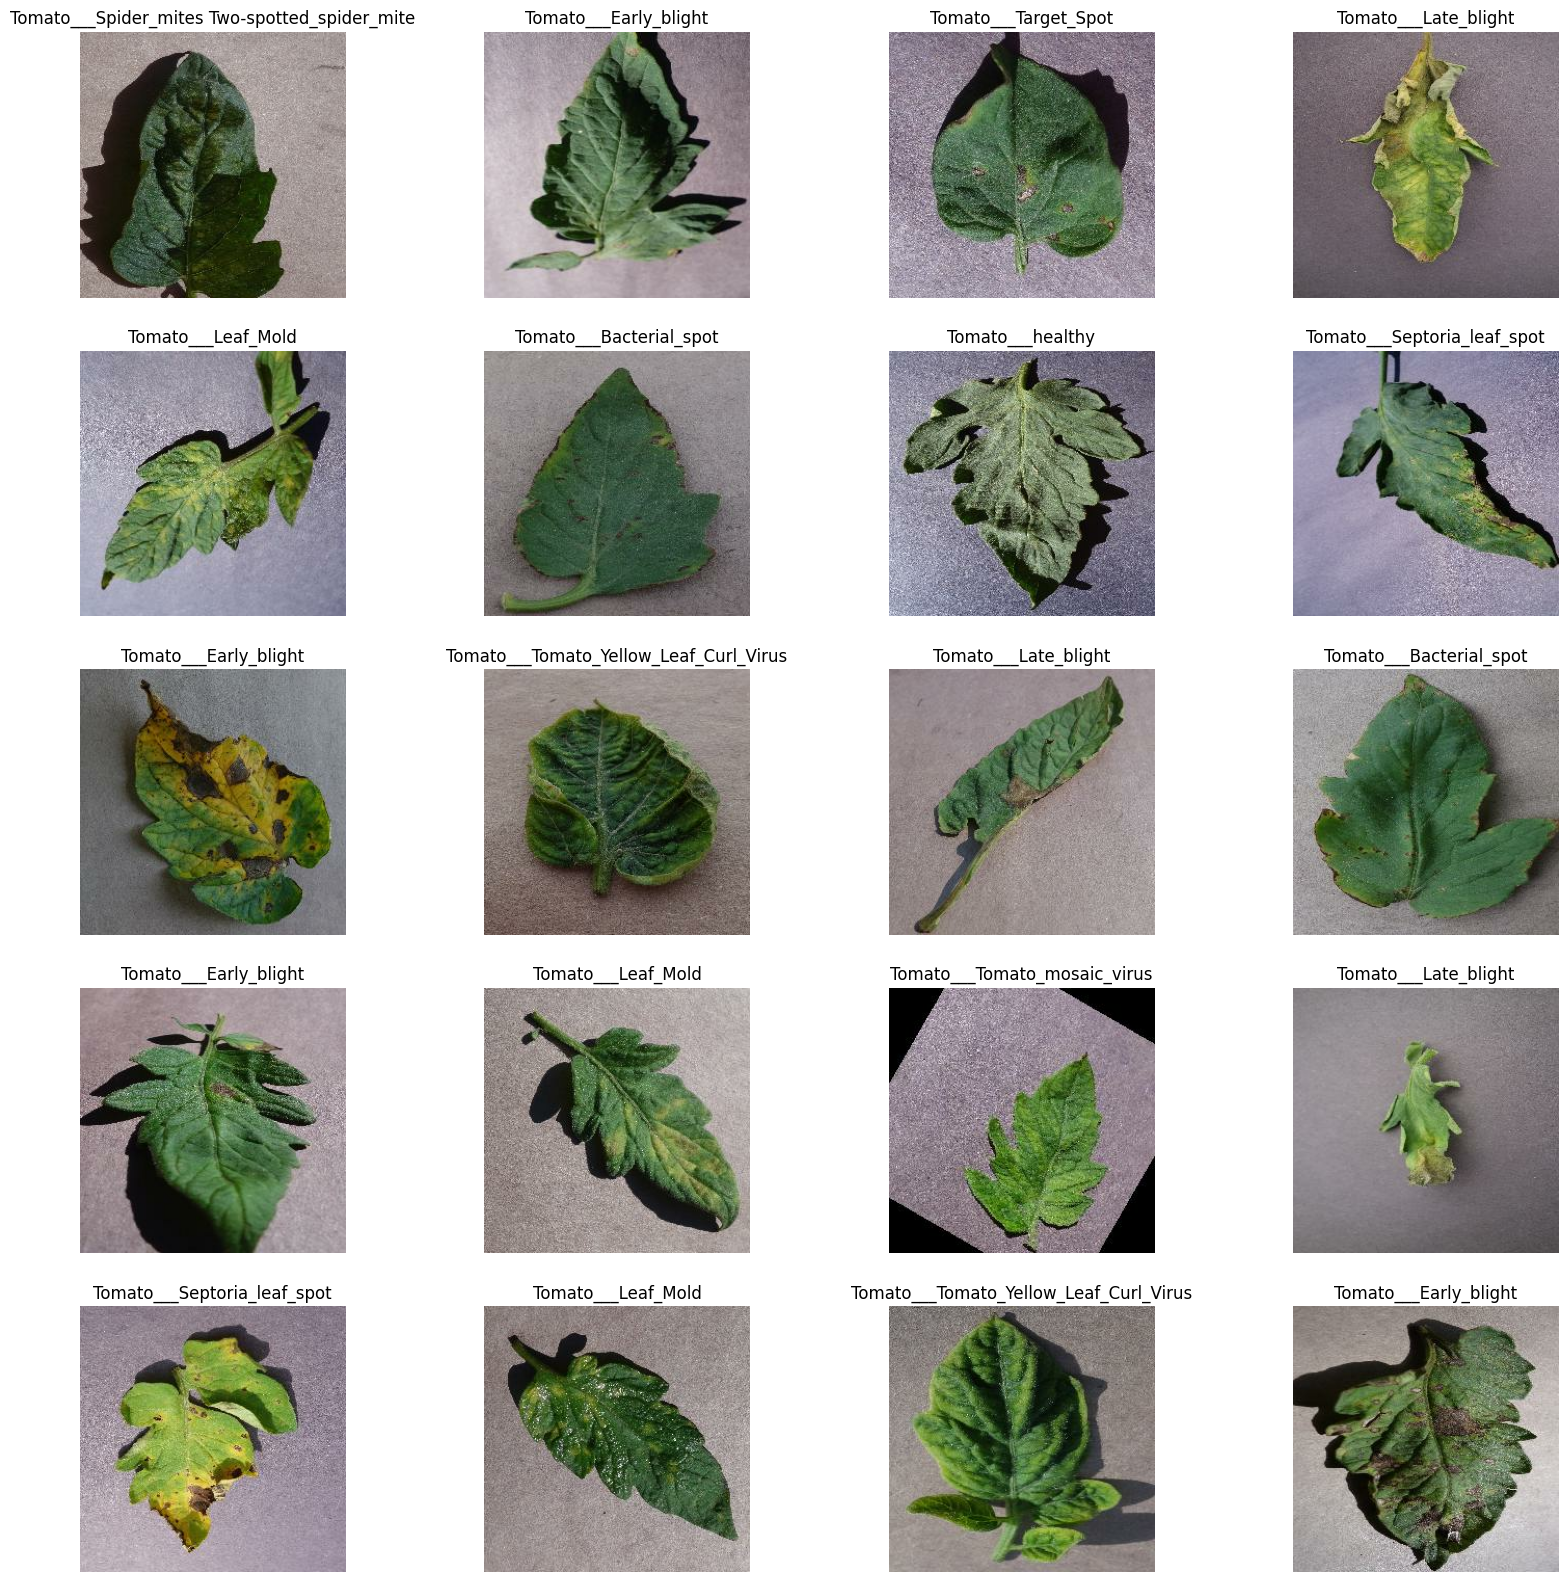

In [14]:
plt.figure(figsize=(20,20))
for image_batch , image_label in train_data.take(1):
    for i in range(20):
        plt.subplot(5,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_label[image_label[i].numpy()])
        plt.axis("off")

# Resizing and Scaling

In [15]:
resizing_and_rescaling = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(256,256),
    tf.keras.layers.experimental.preprocessing.Rescaling(1.0/255)
])

# Data Augmentation

In [16]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomContrast(0.3),
    tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.3),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2)
])

# CNN Model

In [17]:
IMAGE_SIZE=256
CHANNELS=3
BATCH_SIZE=64
EPOCHS=10

input_shape=(BATCH_SIZE , IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model= tf.keras.models.Sequential([
  resizing_and_rescaling,
  data_augmentation,
  # Convolution layer 1
  tf.keras.layers.Conv2D(filters=120, kernel_size=(3,3), strides=(1,1),padding='same',activation='relu',input_shape=input_shape),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  # Convolution layer 2
  tf.keras.layers.Conv2D(filters=100, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  # Convolution layer 3
  tf.keras.layers.Conv2D(filters=80, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),
  # Convolution layer 4
  tf.keras.layers.Conv2D(filters=60, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'),
  tf.keras.layers.MaxPool2D(pool_size=(2,2)),

  # Flatten Layers
  tf.keras.layers.Flatten(),

  # Dense layers
  tf.keras.layers.Dense(units=1000,activation='relu'),
  tf.keras.layers.Dropout(0.4),
  tf.keras.layers.Dense(units=500,activation='relu'),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(units=100,activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(units=10,activation='softmax')

])

model.build(input_shape=input_shape)

In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (64, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (64, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (64, 256, 256, 120)       3360      
                                                                 
 max_pooling2d (MaxPooling2  (64, 128, 128, 120)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (64, 128, 128, 100)       108100    
                                                                 
 max_pooling2d_1 (MaxPoolin  (64, 64, 64, 100)         0         
 g2D)                                                 

In [ ]:
model.compile(optimizer="adam",
             loss="sparse_categorical_crossentropy",
             metrics=["accuracy"])

history = model.fit(train_data ,  batch_size=64 ,epochs=30,
                verbose=1,
                validation_data=val_data) # epochs=5

Epoch 1/30
287/287 [==============================] - 117s 335ms/step - loss: 2.2941 - accuracy: 0.1126 - val_loss: 2.4222 - val_accuracy: 0.1400
Epoch 2/30
287/287 [==============================] - 90s 312ms/step - loss: 2.0584 - accuracy: 0.2313 - val_loss: 2.0884 - val_accuracy: 0.2800
Epoch 3/30
287/287 [==============================] - 91s 314ms/step - loss: 1.6388 - accuracy: 0.4050 - val_loss: 1.4184 - val_accuracy: 0.5800
Epoch 4/30
287/287 [==============================] - 91s 313ms/step - loss: 1.3103 - accuracy: 0.5355 - val_loss: 1.1554 - val_accuracy: 0.6200
Epoch 5/30
287/287 [==============================] - 90s 312ms/step - loss: 1.0281 - accuracy: 0.6360 - val_loss: 0.9917 - val_accuracy: 0.7000
Epoch 6/30
287/287 [==============================] - 90s 312ms/step - loss: 0.8898 - accuracy: 0.6914 - val_loss: 1.0157 - val_accuracy: 0.6600
Epoch 7/30
287/287 [==============================] - 90s 313ms/step - loss: 0.7848 - accuracy: 0.7249 - val_loss: 0.6979 - val_a

# Accuracy and Loss

In [ ]:
loss,acc = model.evaluate(train_data)
print("Loss on Train data:",loss)
print("Accuracy on Train data:",acc)

loss1,acc1 = model.evaluate(test_data)

print("Loss on Test data:",loss1)
print("Accuracy on Test data:",acc1)

287/287 [==============================] - 27s 93ms/step - loss: 0.3604 - accuracy: 0.8809
Loss on Train data: 0.3604036867618561
Accuracy on Train data: 0.8809484839439392
72/72 [==============================] - 7s 87ms/step - loss: 0.3989 - accuracy: 0.8707
Loss on Test data: 0.3988918960094452
Accuracy on Test data: 0.8706651926040649


In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss = history.history["val_loss"]

In [ ]:
EPOCHS=25
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc, label="Training Accuracy")
plt.plot(range(EPOCHS),val_acc, label="Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

#plt.figure(figsize=(6,6))
plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss, label="Training Loss")
plt.plot(range(EPOCHS),val_loss, label="Validation Loss")
plt.legend(loc="lower right")
plt.title("Training and Validation Loss")
plt.show()

# Image Prediction

In [ ]:
def Prediction(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array((images[i].numpy()))
    img_array = tf.expand_dims(img_array,0)     # create a batch

    predictions = model.predict(img_array)

    predicted_class = class_label[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)

    return predicted_class , confidence

1/1 [==============================] - 0s 41ms/step


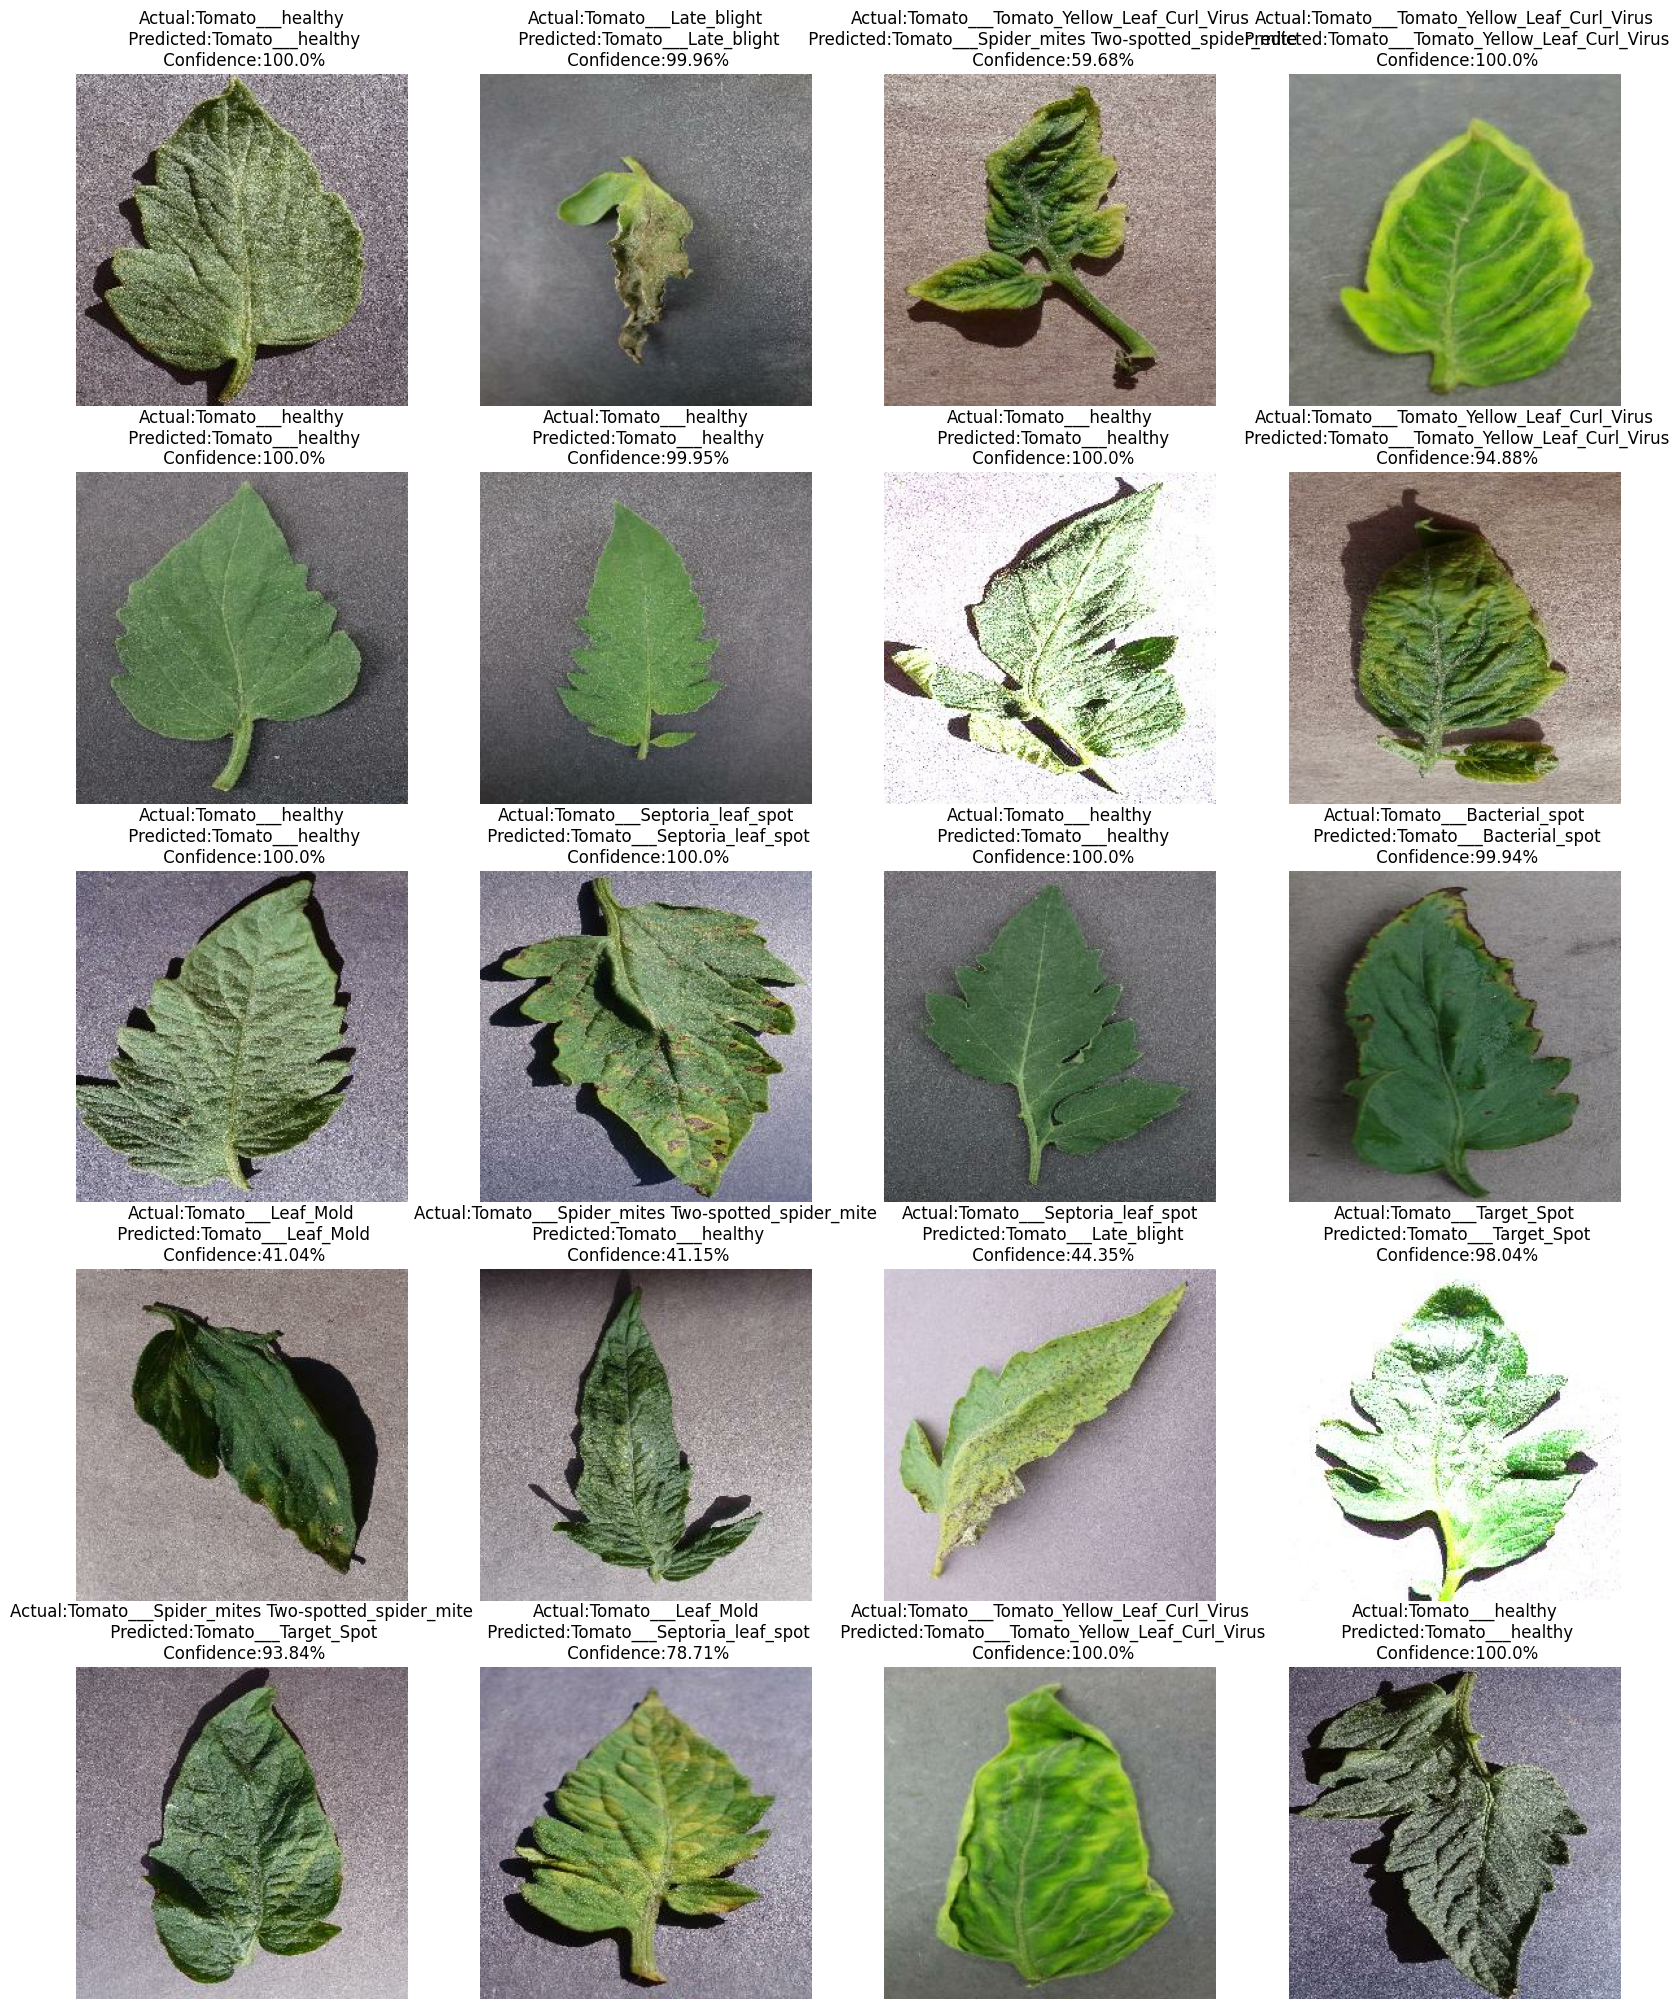

In [ ]:
plt.figure(figsize=(20,25))
for images , labels in test_data.take(1):
    for i in range(20):
        ax = plt.subplot(5,4,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        #plt.title(class_label[labels[i]])


        predicted_class , confidence = Prediction(model,images[i].numpy())
        actual_class = class_label[labels[i]]
        plt.title(f"Actual:{actual_class}\n Predicted:{predicted_class}\n Confidence:{confidence}%")
        plt.axis("off")